In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




1.   prepare X, and Y
2.   seperate it into train and test set
3.   setup xgboost parameters
4.   fit data
5.   predict



In [56]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from keras import backend as K
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from keras.utils import np_utils
import xgboost as xgb
import gc
np.set_printoptions(threshold=sys.maxsize)

In [47]:
main_path = 'drive/MyDrive/Colab Notebooks/dsai_hw4/dataset'

orders_DF = pd.read_csv(os.path.join(main_path, 'orders.csv'))  
prior_order_DF = pd.read_csv(os.path.join(main_path, 'order_products__prior.csv')) 
train_order_DF = pd.read_csv(os.path.join(main_path, 'order_products__train.csv')) 
products_DF = pd.read_csv(os.path.join(main_path, 'products.csv'))

In [48]:
orders_prior = orders_DF.loc[np.where(orders_DF['eval_set'] == 'prior')]
orders_train = orders_DF.loc[np.where(orders_DF['eval_set'] == 'train')]
orders_test  = orders_DF.loc[np.where(orders_DF['eval_set'] == 'test')] 
# orders_test = orders_DF.loc[orders_DF.eval_set=='test',('user_id', 'order_id')]
print('Prior case:', len(orders_prior))
print('Train case:', len(orders_train))
print('Test case:', len(orders_test))

Prior case: 3214874
Train case: 131209
Test case: 75000


In [49]:
# del products_order
# del train_dataframe
# del test_order
# del test_dataframe

# products_order = pd.concat([prior_order_DF, train_order_DF], axis=0)
# print(orders_DF[orders_DF['eval_set']=='test'].count())
train_dataframe = orders_train.merge(train_order_DF, how='inner', on='order_id')
prior_dataframe = orders_prior.merge(prior_order_DF, how='inner', on='order_id')
# test_dataframe  = orders_test.merge()

print(train_dataframe)
print(prior_dataframe)

         order_id  user_id eval_set  ...  product_id  add_to_cart_order  reordered
0         1187899        1    train  ...         196                  1          1
1         1187899        1    train  ...       25133                  2          1
2         1187899        1    train  ...       38928                  3          1
3         1187899        1    train  ...       26405                  4          1
4         1187899        1    train  ...       39657                  5          1
...           ...      ...      ...  ...         ...                ...        ...
1384612    272231   206209    train  ...       40603                  4          0
1384613    272231   206209    train  ...       15655                  5          0
1384614    272231   206209    train  ...       42606                  6          0
1384615    272231   206209    train  ...       37966                  7          0
1384616    272231   206209    train  ...       39216                  8          1

[13

In [44]:
test_user_id_list = orders_test['user_id']
print(len(test_user_id_list))
count = 0

# if orders_DF[orders_DF['user_id'] in test_user_id_list]:
  # count = count + 1

# print(count)

75000


In [50]:
train_dataframe['reordered'] = train_dataframe['reordered'].fillna(0)
# train_dataframe = train_dataframe.set_index(['user_id','product_id'])
# train_dataframe = train_dataframe.drop(['eval_set','order_id'], axis=1)

In [53]:
X = train_dataframe[['user_id','product_id','order_id','add_to_cart_order','order_number','order_dow','order_hour_of_day']]
Y = train_dataframe['reordered'].astype(np.int)
print(X)
print(Y)

         user_id  product_id  ...  order_dow  order_hour_of_day
0              1         196  ...          4                  8
1              1       25133  ...          4                  8
2              1       38928  ...          4                  8
3              1       26405  ...          4                  8
4              1       39657  ...          4                  8
...          ...         ...  ...        ...                ...
1384612   206209       40603  ...          6                 14
1384613   206209       15655  ...          6                 14
1384614   206209       42606  ...          6                 14
1384615   206209       37966  ...          6                 14
1384616   206209       39216  ...          6                 14

[1384617 rows x 7 columns]
0          1
1          1
2          1
3          1
4          1
          ..
1384612    0
1384613    0
1384614    0
1384615    0
1384616    1
Name: reordered, Length: 1384617, dtype: int64


In [54]:
x_train, x_test, y_train, y_test = train_test_split(X,Y , test_size = 0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1107693, 7)
(1107693,)
(276924, 7)
(276924,)


(1107693, 7)
(1107693,)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_boost_round=10, objective='binary:logistic',
              parameters={'colsample_bytree': '0.5', 'eval_metric': 'logloss',
                          'gpu_id': '0', 'max_depth': '5', 'subsample': '0.75',
                          'tree_method': 'gpu_hist'},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'num_boost_round': 10,
 'objective': 'binary:logistic',
 'parameters': {'colsample_bytree': '0.5',
  'eval_metric': 'logloss',
  'gpu_id': '0',
  'max_depth': '5',
  'subsample': '0.75',
  'tree_method': 'gpu_hist'},
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

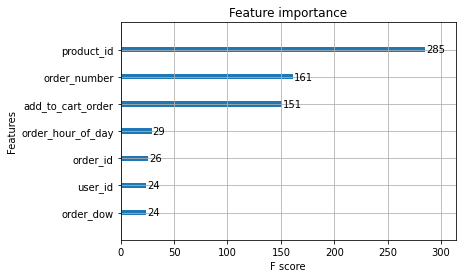

In [55]:
parameters = {'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.5',    # 0.4
              'subsample':'0.75',
              'gpu_id':'0',
              'tree_method':'gpu_hist'
             }
# X_train, y_train = x_train.drop('reordered', axis=1), x_train.reordered.astype(np.int)
print(x_train.shape)
print(y_train.shape)
XGB = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)
model = XGB.fit(x_train, y_train)
print(model)
xgb.plot_importance(model)
model.get_xgb_params()


In [60]:
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
fl_score = f1_score(y_test, y_pred)

print(acc)
print(fl_score)
print(y_pred.shape)

0.6580000288887926
0.7420497009445577
(276924,)
